<a   href="https://colab.research.google.com/github/N-Nieto/OHBM_SEA-SIG_Educational_Course/blob/master/01_basic_ML/01_basics_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Basic Machine Learning

##  1. Set up

In [2]:
# libraries for data analysis
import numpy as np
import pandas as pd
# libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# read the behavioural data
df_behav = pd.read_csv("../data/cleaned_IXI_behavioural.csv", index_col=0)

# get the imaging data: we will use gray matter volume (GMV) 
# of 100 cortical parcels from the Schaefer 100x17 parcellation
df_GMV = pd.read_csv("../data/cleaned_VBM_GM_Schaefer100x17_mean_aggregation.csv", index_col=0)
columns_GMV = df_GMV.columns.tolist()

In [ ]:
# combine behavioural and GMV data
# as the subject IDs are the index, we can use join
df_data = df_behav.join(df_GMV, how="inner")
print(df_data.head())

# filter height > 120 and < 210 (what are the units? what other values are there?)
df_data = df_data[(df_data["HEIGHT"] > 120) & (df_data["HEIGHT"] < 210)]
print(f"Number of subjects: {df_data.shape[0]}, Number of features: {len(columns_GMV)}")

            SEX_ID (1=m, 2=f)  HEIGHT  WEIGHT         DOB  STUDY_DATE  \
subjectID                                                               
sub-IXI002                  2     164      58  1970-01-30  2005-11-18   
sub-IXI012                  1     175      70  1966-08-20  2005-06-01   
sub-IXI013                  1     182      70  1958-09-15  2005-06-01   
sub-IXI014                  2     163      65  1971-03-15  2005-06-09   
sub-IXI015                  1     181      90  1981-03-11  2005-06-23   

                  AGE  LH_VisCent_ExStr_1  LH_VisCent_ExStr_2  \
subjectID                                                       
sub-IXI002  35.800137            0.437949            0.427801   
sub-IXI012  38.781656            0.499554            0.484625   
sub-IXI013  46.710472            0.412590            0.416333   
sub-IXI014  34.236824            0.425624            0.351744   
sub-IXI015  24.284736            0.391679            0.390837   

            LH_VisCent_Striate_1

## 2. First prediction model

OLS performance:
Training: r=0.73, r2=0.53
Test    : r=0.38, r2=0.01


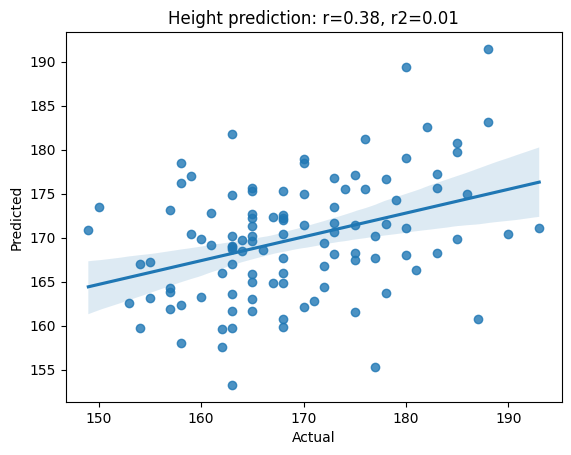

In [ ]:
# A model to predict height of a person using their neuroimaging data. 
# We will use a simple linear regression model.
# The features are the gray matter volume of different brain regions. 
# The target is the height of the person.
from sklearn.linear_model import LinearRegression

# do train-test split
# the goal of train-test split is to evaluate the model on unseen data
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_data, test_size=0.2, random_state=1)

# train a model
# OLS regression model
model = LinearRegression()
# fit the model: we need both features (X) and target (y)
model.fit(X=train_data[columns_GMV], y=train_data["HEIGHT"])

# predict
# we only need features (X)
# the model will predict the target (y)
y_pred = model.predict(X=test_data[columns_GMV])

# evaluate the model: we know the true target values
y_true = test_data["HEIGHT"].values
# get correlation and r2_Score
r = np.corrcoef(y_true, y_pred)[0, 1]
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)

# also check the training performance
y_train_pred = model.predict(X=train_data[columns_GMV])
y_train_true = train_data["HEIGHT"].values

r_train = np.corrcoef(y_train_true, y_train_pred)[0, 1]
r2_train = r2_score(y_train_true, y_train_pred)

print("OLS performance:")
print(f"Training: r={r_train:.2f}, r2={r2_train:.2f}")
print(f"Test    : r={r:.2f}, r2={r2:.2f}")

# scatterplot true versus predicted test set values
sns.regplot(x=y_true, y=y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Height prediction: r={r:.2f}, r2={r2:.2f}")
plt.show()


Ridge performance:
Training: r=0.64, r2=0.40
Test    : r=0.51, r2=0.25


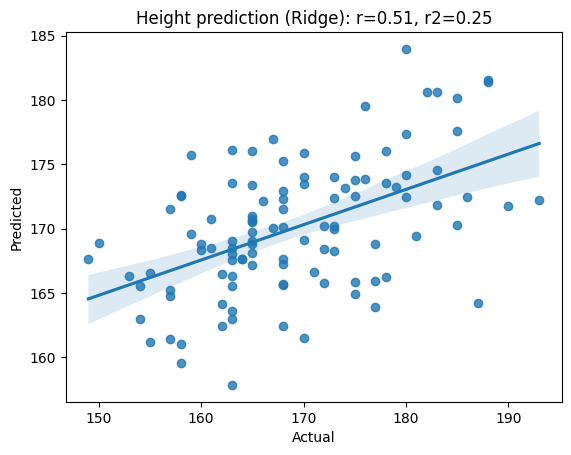

In [15]:
# Can we improve with L2 regularization (Ridge regression)? 
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X=train_data[columns_GMV], y=train_data["HEIGHT"])
y_pred = model.predict(X=test_data[columns_GMV])

r = np.corrcoef(y_true, y_pred)[0, 1]
r2 = r2_score(y_true, y_pred)

# also check training performance
y_train_pred = model.predict(X=train_data[columns_GMV])
r_train = np.corrcoef(y_train_true, y_train_pred)[0, 1]
r2_train = r2_score(y_train_true, y_train_pred)
print("Ridge performance:")
print(f"Training: r={r_train:.2f}, r2={r2_train:.2f}")
print(f"Test    : r={r:.2f}, r2={r2:.2f}")

sns.regplot(x=y_true, y=y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Height prediction (Ridge): r={r:.2f}, r2={r2:.2f}")
plt.show()

1. Why did the performance improve?
2. Why is the test performance lower than the train performance?

Fold 1: r = 0.511, r2 = 0.249
Fold 2: r = 0.597, r2 = 0.350
Fold 3: r = 0.537, r2 = 0.285
Fold 4: r = 0.506, r2 = 0.246
Fold 5: r = 0.575, r2 = 0.321
Performance:
Train: Mean r = 0.630, Mean r2 = 0.387
Test : Mean r = 0.545, Mean r2 = 0.290


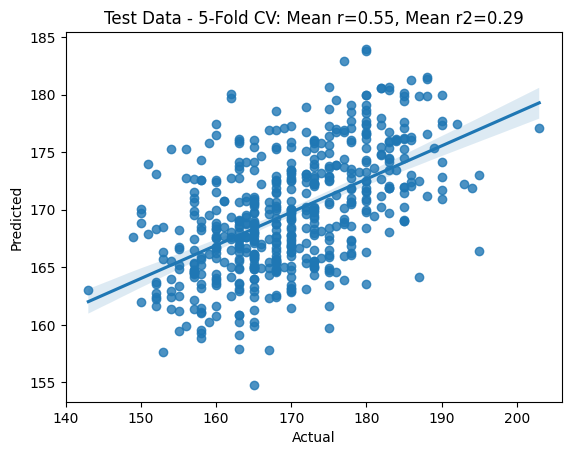

In [18]:
# k-fold cross-validation: more efficient use of data
# we will use 5-fold cross-validation
from sklearn.model_selection import KFold

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
all_true = []
all_pred = []
test_r_scores = []
test_r2_scores = []
train_r_scores = []
train_r2_scores = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Train Ridge model
    model = Ridge()
    model.fit(train_data[columns_GMV], train_data["HEIGHT"])

    # Predict
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data["HEIGHT"].values

    # Store for global plot
    all_true.extend(y_true)
    all_pred.extend(y_pred)

    # Evaluate
    test_r = np.corrcoef(y_true, y_pred)[0, 1]
    test_r2 = r2_score(y_true, y_pred)
    test_r_scores.append(test_r)
    test_r2_scores.append(test_r2)

    print(f"Fold {fold + 1}: r = {test_r:.3f}, r2 = {test_r2:.3f}")

    # Evaluate on the training data as well (do we overfit?)
    y_train_pred = model.predict(train_data[columns_GMV])
    y_train_true = train_data["HEIGHT"].values
    train_r = np.corrcoef(y_train_true, y_train_pred)[0, 1]
    train_r2 = r2_score(y_train_true, y_train_pred)
    train_r_scores.append(train_r)
    train_r2_scores.append(train_r2)

# Print performance
print('Performance:')
print(f"Train: Mean r = {np.mean(train_r_scores):.3f}, Mean r2 = {np.mean(train_r2_scores):.3f}")
print(f"Test : Mean r = {np.mean(test_r_scores):.3f}, Mean r2 = {np.mean(test_r2_scores):.3f}")

# Overall plot
sns.regplot(x=all_true, y=all_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(
    f"Test Data - 5-Fold CV: Mean r={np.mean(test_r_scores):.2f}, Mean r2={np.mean(test_r2_scores):.2f}"
)
plt.show()


 Oh but we have one hyperparameter for Ridge:
 
`alpha{float, ndarray of shape (n_targets,)}, default=1.0
    Constant that multiplies the L2 term, controlling regularization strength. alpha must be a non-negative float i.e. in [0, inf).`

How to choose it?
Nested cross-validation!

Optimizing alpha values using nested CV
Fold 1: r = 0.493, r2 = 0.227, alpha = 0.5
Fold 2: r = 0.597, r2 = 0.350, alpha = 1.0
Fold 3: r = 0.549, r2 = 0.299, alpha = 0.5
Fold 4: r = 0.510, r2 = 0.243, alpha = 0.5
Fold 5: r = 0.576, r2 = 0.327, alpha = 0.5
Performance:
Train: Mean r = 0.655, Mean r2 = 0.420
Test : Mean r = 0.545, Mean r2 = 0.289


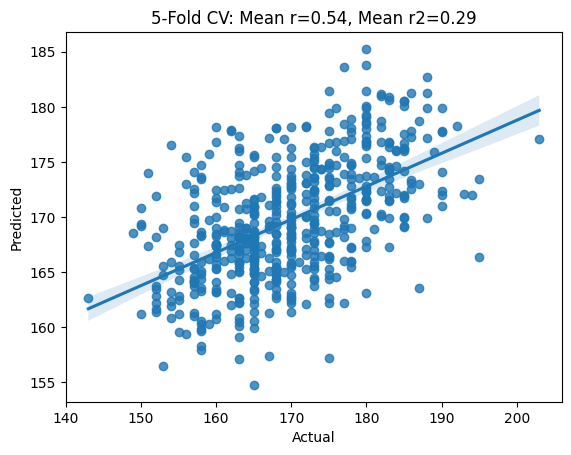

In [ ]:
from sklearn.model_selection import GridSearchCV

# define alpha values to tests
alphas = [0.01, 0.1, 0.5, 1.0, 10.0]
print("Optimizing alpha values using nested CV")

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
all_true = []
all_pred = []
test_r_scores = []
test_r2_scores = []
train_r_scores = []
train_r2_scores = []
best_alphas = []

# outer CV loop
# here we will do "model evaluation"
for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Train Ridge model while optimizing alpha in a for loop
    inner_score_max = -np.inf
    best_alpha = None
    for alpha in alphas:
        # new for loop to test for each alpha
        # we will do an inner cross-validation to find the best alpha
        # for each alpha, we will do a 5-fold cross-validation on the training data
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)
        inner_scores = []
        # inner CV loop
        # here we will do "model selection"
        for train_index_inner, test_index_inner in inner_cv.split(train_data):
            train_data_inner = train_data.iloc[train_index_inner]
            test_data_inner = train_data.iloc[test_index_inner]
            model = Ridge(alpha=alpha)
            model.fit(train_data_inner[columns_GMV], train_data_inner["HEIGHT"])
            inner_scores.append(
                model.score(test_data_inner[columns_GMV], test_data_inner["HEIGHT"])
            )
        mean_inner_score = np.mean(inner_scores)
        # check if this is the best alpha so far
        if mean_inner_score > inner_score_max:
            inner_score_max = mean_inner_score
            best_alpha = alpha

    # fit model with best alpha found in inner loop
    # use the entire training data
    best_alphas.append(best_alpha)
    model = Ridge(alpha=best_alpha)
    model.fit(train_data[columns_GMV], train_data["HEIGHT"])

    # Predict
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data["HEIGHT"].values

    # Store for global plot
    all_true.extend(y_true)
    all_pred.extend(y_pred)

    # Evaluate
    test_r = np.corrcoef(y_true, y_pred)[0, 1]
    test_r2 = r2_score(y_true, y_pred)
    test_r_scores.append(test_r)
    test_r2_scores.append(test_r2)

    print(
        f"Fold {fold + 1}: r = {test_r:.3f}, r2 = {test_r2:.3f}, alpha = {best_alpha}"
    )

    # Evaluate on the training data as well (do we overfit?)
    y_train_pred = model.predict(train_data[columns_GMV])
    y_train_true = train_data["HEIGHT"].values
    train_r = np.corrcoef(y_train_true, y_train_pred)[0, 1]
    train_r2 = r2_score(y_train_true, y_train_pred)
    train_r_scores.append(train_r)
    train_r2_scores.append(train_r2)

print('Performance:')
print(f"Train: Mean r = {np.mean(train_r_scores):.3f}, Mean r2 = {np.mean(train_r2_scores):.3f}")
print(f"Test : Mean r = {np.mean(test_r_scores):.3f}, Mean r2 = {np.mean(test_r2_scores):.3f}")

# Overall plot
sns.regplot(x=all_true, y=all_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"5-Fold CV: Mean r={np.mean(test_r_scores):.2f}, Mean r2={np.mean(test_r2_scores):.2f}")
plt.show()

1. What is the difference between train-test split and k-fold cross-validation?
2. What is the purpose of hyperparameter tuning?
3. What is the difference between hyperparameters and model parameters?
4. What to do if the selected hyperparameter is at the edge of the search space?

# scikit-learn's GridSearchCV can help with hyperparameter tuning

Optimizing alpha values using grid search
Fold 1: r = 0.589, r2 = 0.345, alpha = 1.0
Fold 2: r = 0.579, r2 = 0.317, alpha = 1.0
Fold 3: r = 0.612, r2 = 0.369, alpha = 1.0
Fold 4: r = 0.547, r2 = 0.283, alpha = 1.0
Fold 5: r = 0.624, r2 = 0.376, alpha = 1.0


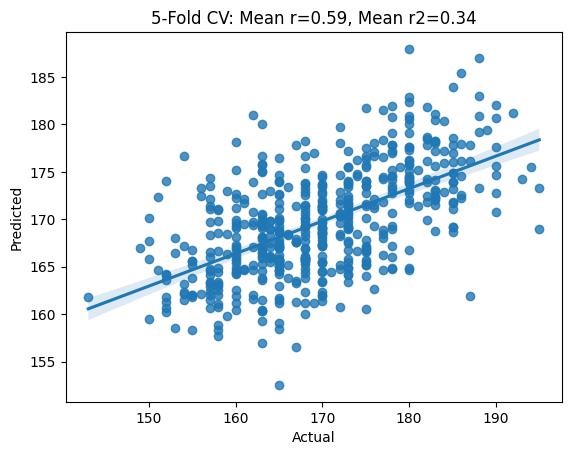

In [ ]:
from sklearn.model_selection import GridSearchCV

# define the grid search for alpha values
param_grid = {"alpha": [0.01, 0.1, 0.5, 1.0, 10.0]}
print("Optimizing alpha values using grid search")

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
all_true = []
all_pred = []
r_list = []
r2_list = []
best_alphas = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Find best alpha using GridSearchCV instead of for loop
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)
    # define the model as a GridSearchCV object
    model = GridSearchCV(
        Ridge(), param_grid, cv=inner_cv, scoring="r2"
    )  # r2 uses r2_score
    # fit will find the best alpha: it will do the inner cross-validation
    model.fit(train_data[columns_GMV], train_data["HEIGHT"])

    # when we predict using this model it will use the "best" alpha value, let's save that value
    best_alpha = model.best_params_["alpha"]
    best_alphas.append(best_alpha)

    # Predict using the best alpha
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data["HEIGHT"].values

    # Store for global plot
    all_true.extend(y_true)
    all_pred.extend(y_pred)

    # Evaluate
    r = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    r_list.append(r)
    r2_list.append(r2)

    print(f"Fold {fold + 1}: r = {r:.3f}, r2 = {r2:.3f}, alpha = {best_alpha}")

# Overall plot
sns.regplot(x=all_true, y=all_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"5-Fold CV: Mean r={np.mean(r_list):.2f}, Mean r2={np.mean(r2_list):.2f}")
plt.show()

In [20]:
# let's move to classification

# first create a split for height
# using median height as cutoff
# according to NHS mean height for men is 175 and for women is 162
# let's take average of these two values as cutoff
height_cutoff = (175 + 162) / 2
print(f"Height cutoff: {height_cutoff} cm")

# create a new column in df for tall (1) and short (0)
df_data["TALL"] = (df_data["HEIGHT"] >= height_cutoff).astype(int)
df_data["TALL"].value_counts()  # the classes look reasonably balanced

Height cutoff: 168.5 cm


TALL
1    274
0    266
Name: count, dtype: int64

In [23]:
# classification needs different models and metrics
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# define the grid search for alhpa values
param_grid = {"alpha": [0.01, 0.1, 0.5, 1.0, 10.0]}
print("Optimizing alpha values using grid search")

# Set up CV
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
test_accuracies = []
test_roc_aucs = []
train_accuracies = []
train_roc_aucs = []
best_alphas = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Train Ridge model: now using GridSearchCV instead of for loop
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)

    model = GridSearchCV(
        RidgeClassifier(), param_grid, cv=inner_cv, scoring="accuracy"
    )  # accuracy for classification
    model.fit(train_data[columns_GMV], train_data["TALL"])
    # when we predict using this model it will use the "best" alpha value, let's save that value
    best_alpha = model.best_params_["alpha"]
    best_alphas.append(best_alpha)

    # Predict
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data["TALL"].values

    # Evaluate
    test_acc = accuracy_score(y_true, y_pred)
    test_roc_auc = roc_auc_score(y_true, y_pred)
    test_accuracies.append(test_acc)
    test_roc_aucs.append(test_roc_auc)

    print(
        f"Fold {fold + 1}: accuracy = {test_acc:.3f}, roc_auc = {test_roc_auc:.3f}, alpha = {best_alpha}"
    )

    # Evaluate on the training data as well (do we overfit?)
    y_train_pred = model.predict(train_data[columns_GMV])
    y_train_true = train_data["TALL"].values
    train_acc = accuracy_score(y_train_true, y_train_pred)
    train_roc_auc = roc_auc_score(y_train_true, y_train_pred)
    train_accuracies.append(train_acc)
    train_roc_aucs.append(train_roc_auc)


# print mean accuracy
print('Performance:')
print(
    f"Train: Mean acc={np.mean(train_accuracies):.3f}, Mean ROC AUC={np.mean(train_roc_aucs):.3f}"
)
print(
    f"Test: Mean acc={np.mean(test_accuracies):.3f}, Mean ROC AUC={np.mean(test_roc_aucs):.3f}"
)

Optimizing alpha values using grid search
Fold 1: accuracy = 0.667, roc_auc = 0.671, alpha = 0.5
Fold 2: accuracy = 0.694, roc_auc = 0.706, alpha = 0.5
Fold 3: accuracy = 0.685, roc_auc = 0.684, alpha = 1.0
Fold 4: accuracy = 0.694, roc_auc = 0.690, alpha = 1.0
Fold 5: accuracy = 0.713, roc_auc = 0.714, alpha = 0.5
Performance:
Train: Mean acc=0.767, Mean ROC AUC=0.767
Test: Mean acc=0.691, Mean ROC AUC=0.693


In [ ]:
# we can also scale the data before classification
# use sklearn's pipeline for that 
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the pipeline
pipeline = Pipeline([("scaler", StandardScaler()), ("ridge", RidgeClassifier())])

# define the grid search for alpha values
# note the change in the key name to match the pipeline step
param_grid = {
    "ridge__alpha": [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0, 100, 1000, 10000, 100000]
}
print("Optimizing alpha values using grid search")

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
test_accuracies = []
test_roc_aucs = []
train_accuracies = []
train_roc_aucs = []
best_alphas = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Train Ridge model: now using GridSearchCV instead of for loop
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)

    # Use a pipeline to scale the data before classification

    model = GridSearchCV(
        pipeline, param_grid, cv=inner_cv, scoring="accuracy"
    )  # accuracy for classification
    model.fit(train_data[columns_GMV], train_data["TALL"])
    # when we predict using this model it will use the "best" alpha value, let's save that value
    best_alpha = model.best_params_["ridge__alpha"]
    best_alphas.append(best_alpha)

    # Predict
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data["TALL"].values

    # Evaluate
    test_acc = accuracy_score(y_true, y_pred)
    test_roc_auc = roc_auc_score(y_true, y_pred)
    test_accuracies.append(test_acc)
    test_roc_aucs.append(test_roc_auc)

    print(
        f"Fold {fold + 1}: accuracy = {test_acc:.3f}, roc_auc = {test_roc_auc:.3f}, alpha = {best_alpha}"
    )

    # Evaluate on the training data as well (do we overfit?)
    y_train_pred = model.predict(train_data[columns_GMV])
    y_train_true = train_data["TALL"].values
    train_acc = accuracy_score(y_train_true, y_train_pred)
    train_roc_auc = roc_auc_score(y_train_true, y_train_pred)
    train_accuracies.append(train_acc)
    train_roc_aucs.append(train_roc_auc)


# print mean accuracy
print('Performance:')
print(
    f"Train: Mean acc={np.mean(train_accuracies):.3f}, Mean ROC AUC={np.mean(train_roc_aucs):.3f}"
)
print(
    f"Test: Mean acc={np.mean(test_accuracies):.3f}, Mean ROC AUC={np.mean(test_roc_aucs):.3f}"
)

Optimizing alpha values using grid search
Fold 1: accuracy = 0.657, roc_auc = 0.663, alpha = 100
Fold 2: accuracy = 0.722, roc_auc = 0.727, alpha = 1000
Fold 3: accuracy = 0.685, roc_auc = 0.686, alpha = 1000
Fold 4: accuracy = 0.694, roc_auc = 0.691, alpha = 100
Fold 5: accuracy = 0.657, roc_auc = 0.657, alpha = 1000
Performance:
Train: Mean acc=0.745, Mean ROC AUC=0.745
Test: Mean acc=0.683, Mean ROC AUC=0.685
